In [23]:
# Cell 1: Setup (Enhanced with Directory Checking)
"""
Air Quality Index - Model Training
Notebook 2: Building and Training ML Models
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

warnings.filterwarnings('ignore')

# Project structure setup
def setup_directories():
    """Ensure all required directories exist"""
    if 'notebooks' in os.getcwd():
        dirs = ['../data/raw', '../data/processed', '../models', '../screenshots', '../reports']
    else:
        dirs = ['data/raw', 'data/processed', 'models', 'screenshots', 'reports']
    
    print("Checking project structure...")
    for directory in dirs:
        if os.path.exists(directory):
            print(f"  ✅ {directory}")
        else:
            print(f"  ⚠️  {directory} (creating...)")
            os.makedirs(directory, exist_ok=True)
            print(f"  ✅ {directory} (created)")
    print()

# Run setup
setup_directories()

# Import ML libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("✅ All libraries imported successfully!")

Checking project structure...
  ✅ ../data/raw
  ✅ ../data/processed
  ✅ ../models
  ✅ ../screenshots
  ✅ ../reports

✅ All libraries imported successfully!


In [13]:
# Cell 2: Load Data
"""
Load preprocessed data
"""

# Load data
df = pd.read_csv('../data/processed/aqi_data_explored.csv')

# Remove category column if it exists
if 'AQI_Category' in df.columns:
    df = df.drop('AQI_Category', axis=1)

print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (1000, 11)


,PM2.5,PM10,NO2,SO2,CO,Temperature,Humidity,Wind_Speed,Traffic_Volume,Industrial_Activity,AQI
0,81.162623,71.837220,33.553512,55.452725,2.902780,21.809066,68.895417,0.775989,1997,50.574230,66.410828
1,190.635718,171.732265,32.228092,64.751105,4.046618,24.203070,40.343182,3.735451,6464,81.710213,153.111833
2,149.078849,264.424834,91.562912,23.785092,3.824789,35.636422,82.343674,16.624916,8564,86.100882,130.323690
3,123.745112,225.022968,32.459158,51.865557,0.854110,20.200132,66.786974,15.335367,4187,61.562440,113.777022
4,39.643542,245.837121,34.475475,47.880949,0.831322,36.089491,39.432233,7.012854,9564,1.275648,80.433278


In [14]:
# Cell 3: Prepare Data
"""
Split features and target, create train/test sets
"""

# Features and target
X = df.drop('AQI', axis=1)
y = df['AQI']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures: {list(X.columns)}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Data prepared and scaled!")


Features shape: (1000, 10)
Target shape: (1000,)

Features: ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'Temperature', 'Humidity', 'Wind_Speed', 'Traffic_Volume', 'Industrial_Activity']

Training set: 800 samples
Test set: 200 samples
✅ Data prepared and scaled!


In [15]:
# Cell 4: Baseline Model
"""
Train a simple linear regression as baseline
"""

print("="*60)
print("BASELINE MODEL: LINEAR REGRESSION")
print("="*60)

baseline_model = LinearRegression()
baseline_model.fit(X_train_scaled, y_train)
y_pred_baseline = baseline_model.predict(X_test_scaled)

mae_baseline = mean_absolute_error(y_test, y_pred_baseline)
rmse_baseline = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
r2_baseline = r2_score(y_test, y_pred_baseline)

print(f"MAE:  {mae_baseline:.2f}")
print(f"RMSE: {rmse_baseline:.2f}")
print(f"R²:   {r2_baseline:.4f}")


BASELINE MODEL: LINEAR REGRESSION
MAE:  8.31
RMSE: 10.22
R²:   0.9060


In [16]:
# Cell 5: Multiple Models Comparison
"""
Train and compare multiple models
"""

print("="*60)
print("TRAINING MULTIPLE MODELS")
print("="*60)

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'Decision Tree': DecisionTreeRegressor(random_state=42, max_depth=10),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'model': model,
        'predictions': y_pred,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    }
    
    print(f"  MAE:  {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R²:   {r2:.4f}")


TRAINING MULTIPLE MODELS

Training Linear Regression...
  MAE:  8.31
  RMSE: 10.22
  R²:   0.9060

Training Ridge Regression...
  MAE:  8.31
  RMSE: 10.21
  R²:   0.9061

Training Lasso Regression...
  MAE:  8.19
  RMSE: 10.12
  R²:   0.9078

Training Decision Tree...
  MAE:  11.99
  RMSE: 15.17
  R²:   0.7927

Training Random Forest...
  MAE:  9.07
  RMSE: 11.08
  R²:   0.8894

Training Gradient Boosting...
  MAE:  9.16
  RMSE: 11.15
  R²:   0.8880



MODEL COMPARISON
            Model       MAE      RMSE       R2
Linear Regression  8.309583 10.217507 0.906028
 Ridge Regression  8.306077 10.214097 0.906091
 Lasso Regression  8.193338 10.118055 0.907848
    Decision Tree 11.994708 15.174795 0.792722
    Random Forest  9.067634 11.084325 0.889407
Gradient Boosting  9.161297 11.153456 0.888023


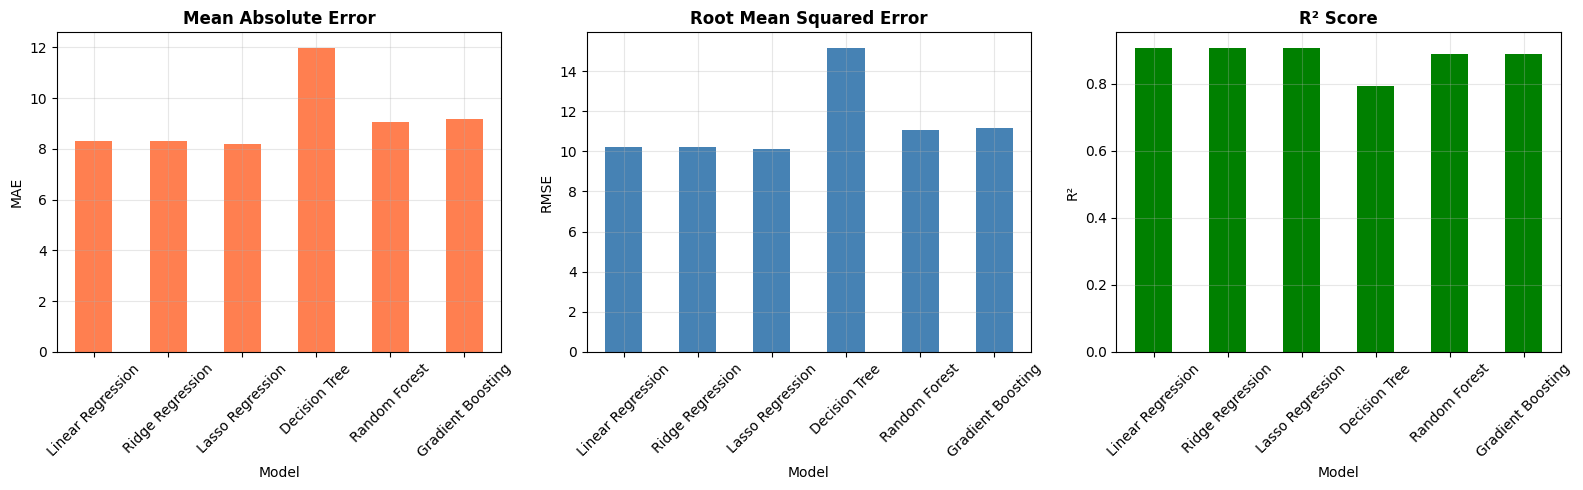

In [17]:
# Cell 6: Model Comparison Visualization
"""
Visualize model performance comparison
"""

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'MAE': [results[m]['MAE'] for m in results],
    'RMSE': [results[m]['RMSE'] for m in results],
    'R2': [results[m]['R2'] for m in results]
})

print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
print(comparison_df.to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

comparison_df.plot(x='Model', y='MAE', kind='bar', ax=axes[0], color='coral', legend=False)
axes[0].set_title('Mean Absolute Error', fontweight='bold')
axes[0].set_ylabel('MAE')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(alpha=0.3)

comparison_df.plot(x='Model', y='RMSE', kind='bar', ax=axes[1], color='steelblue', legend=False)
axes[1].set_title('Root Mean Squared Error', fontweight='bold')
axes[1].set_ylabel('RMSE')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(alpha=0.3)

comparison_df.plot(x='Model', y='R2', kind='bar', ax=axes[2], color='green', legend=False)
axes[2].set_title('R² Score', fontweight='bold')
axes[2].set_ylabel('R²')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../screenshots/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


In [26]:
# Cell 7: Select Best Model
"""
Identify and analyze the best performing model
"""

# Find best model by R² score
best_model_name = comparison_df.loc[comparison_df['R2'].idxmax(), 'Model']

# If you specifically want Random Forest for feature importance
# Uncomment the line below:
# best_model_name = 'Random Forest'

best_model = results[best_model_name]['model']
best_predictions = results[best_model_name]['predictions']

print("="*60)
print(f"BEST MODEL: {best_model_name}")
print("="*60)
print(f"MAE:  {results[best_model_name]['MAE']:.2f}")
print(f"RMSE: {results[best_model_name]['RMSE']:.2f}")
print(f"R²:   {results[best_model_name]['R2']:.4f}")

BEST MODEL: Lasso Regression
MAE:  8.19
RMSE: 10.12
R²:   0.9078


In [19]:
# Cell 8: Hyperparameter Tuning
"""
Fine-tune the best model using GridSearchCV
"""

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

print("="*60)
print("HYPERPARAMETER TUNING")
print("="*60)

if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10]
    }
    
    print("Performing Grid Search... (this may take a few minutes)")
    grid_search = GridSearchCV(
        RandomForestRegressor(random_state=42),
        param_grid,
        cv=3,
        scoring='r2',
        n_jobs=-1
    )
    
    grid_search.fit(X_train_scaled, y_train)
    
    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_:.4f}")
    
    # Use tuned model
    best_model = grid_search.best_estimator_
    best_predictions = best_model.predict(X_test_scaled)
    
    print(f"\nTuned Model Performance:")
    print(f"MAE:  {mean_absolute_error(y_test, best_predictions):.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, best_predictions)):.2f}")
    print(f"R²:   {r2_score(y_test, best_predictions):.4f}")
else:
    print(f"Skipping hyperparameter tuning for {best_model_name}")
    print("Grid search is specifically configured for Random Forest.")
    print("Using the model as-is from Cell 7.")

HYPERPARAMETER TUNING
Skipping hyperparameter tuning for Lasso Regression
Grid search is specifically configured for Random Forest.
Using the model as-is from Cell 7.


In [20]:
# Cell 9: Cross-Validation
"""
Perform cross-validation for robust performance estimate
"""

print("="*60)
print("CROSS-VALIDATION")
print("="*60)

cv_scores = cross_val_score(
    best_model, X_train_scaled, y_train, 
    cv=5, scoring='r2'
)

print(f"Cross-validation R² scores: {cv_scores}")
print(f"Mean CV R²: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


CROSS-VALIDATION
Cross-validation R² scores: [0.91060148 0.91373288 0.90425332 0.91278077 0.89691645]
Mean CV R²: 0.9077 (+/- 0.0126)


In [25]:
# Cell 10: Save Model
"""
Save the trained model for deployment
"""

import joblib
import os

print("="*60)
print("SAVING MODEL")
print("="*60)

# Determine the correct path (handles both running from notebooks/ or project root)
if 'notebooks' in os.getcwd():
    model_dir = '../models'
else:
    model_dir = 'models'

# Check if directory exists, create if not
if not os.path.exists(model_dir):
    print(f"⚠️  Directory '{model_dir}' does not exist. Creating it...")
    try:
        os.makedirs(model_dir, exist_ok=True)
        print(f"✅ Created directory: {model_dir}")
    except Exception as e:
        print(f"❌ Error creating directory: {e}")
        print("Please create the 'models' directory manually and try again.")
        raise
else:
    print(f"✅ Directory '{model_dir}' exists")

# Save model and scaler
try:
    model_path = os.path.join(model_dir, 'random_forest_model.pkl')
    scaler_path = os.path.join(model_dir, 'scaler.pkl')
    
    print(f"\nSaving model to: {model_path}")
    joblib.dump(best_model, model_path)
    
    print(f"Saving scaler to: {scaler_path}")
    joblib.dump(scaler, scaler_path)
    
    # Verify files were created
    model_size = os.path.getsize(model_path) / 1024  # Size in KB
    scaler_size = os.path.getsize(scaler_path) / 1024
    
    print("\n" + "="*60)
    print("✅ MODEL SAVED SUCCESSFULLY!")
    print("="*60)
    print(f"Model file: {model_path} ({model_size:.2f} KB)")
    print(f"Scaler file: {scaler_path} ({scaler_size:.2f} KB)")
    
except Exception as e:
    print(f"\n❌ Error saving model: {e}")
    raise

SAVING MODEL
✅ Directory '../models' exists

Saving model to: ../models/random_forest_model.pkl
Saving scaler to: ../models/scaler.pkl

✅ MODEL SAVED SUCCESSFULLY!
Model file: ../models/random_forest_model.pkl (0.70 KB)
Scaler file: ../models/scaler.pkl (1.18 KB)
